In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Using pytorch torch.nn module to bulit neural networks
PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architectures.
Those building blocks are called modules in PyTorch parlance (such building
blocks are often referred to as layers in other frameworks)

#### 1. Buliding basic linear model

In [2]:
import torch.nn as nn

In [3]:
linear_model = nn.Linear(1, 1)
linear_model

Linear(in_features=1, out_features=1, bias=True)

Mow we have an instance of nn.Linear with one input and one output feature. That
only requires one weight and one bias:

In [4]:
# to get weight and bias of the defined model
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.4664]], requires_grad=True),
 Parameter containing:
 tensor([-0.0791], requires_grad=True))

In [5]:
# Input
x = torch.ones(1)
linear_model(x)

tensor([-0.5454], grad_fn=<AddBackward0>)

Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example

In [6]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5454]], grad_fn=<AddmmBackward>)

In [7]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [8]:
t_c.shape, t_u.shape

(torch.Size([11]), torch.Size([11]))

In [9]:
from torch import optim

linear_model = nn.Linear(1, 1)
# This method call replaces [params]
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

**torch.optim** is a package implementing various optimization algorithms. To use **torch.optim** you have to construct an optimizer object, that will hold the current state and will update the parameters based on the computed gradients.

In [10]:
# to get the list of model parameters to be optimized
# i.e 'Weight' and 'bias'
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.0887]], requires_grad=True),
 Parameter containing:
 tensor([-0.3808], requires_grad=True)]

The optimizer is provided with a list of tensors that were defined with **requires_grad = True**—all Parameters are defined this way by definition, since they need to be optimized by gradient descent. When **training_loss.backward()** is called, grad is accumulated on the leaf nodes of the graph, which are precisely the parameters that were passed to the optimizer.

At this point, the SGD optimizer has everything it needs. When **optimizer.step()**
is called, it will iterate through each *Parameter* and change it by an amount proportional
to what is stored in its grad attribute. Pretty clean design.

In [23]:
# defining the training loop
def training_loop(n_epochs, optimizer, model, loss_fn,
                   t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch%1000 == 0:
            print("Epoch:%d, Training loss:%.4f, Val loss:%.4f" 
                  %(epoch, loss_train, loss_val))

In [12]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

t_u_train = t_u[train_indices].unsqueeze(-1)
t_c_train = t_c[train_indices].unsqueeze(-1)

t_u_val = t_u[val_indices].unsqueeze(-1)
t_c_val = t_c[val_indices].unsqueeze(-1)

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

t_un_train, t_u_train.shape

(tensor([[4.8900],
         [5.5900],
         [5.6300],
         [3.5700],
         [8.1900],
         [3.3900],
         [5.8200],
         [4.8400],
         [6.8400]]),
 torch.Size([9, 1]))

In [49]:
train_indices, t_u_train

(tensor([ 5,  1,  4,  0,  3,  6,  2,  8, 10]),
 tensor([[48.9000],
         [55.9000],
         [56.3000],
         [35.7000],
         [81.9000],
         [33.9000],
         [58.2000],
         [48.4000],
         [68.4000]]))

There’s one last bit that we can leverage from **torch.nn:** the loss. Indeed, nn comes with several common loss functions, among them **nn.MSELoss** (MSE stands for Mean Square Error), which is exactly what we defined earlier as our loss_fn

In [24]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(n_epochs=3000,
              optimizer=optimizer,
              model=linear_model,
              loss_fn=nn.MSELoss(),
              t_u_train=t_un_train,
              t_u_val=t_un_val,
              t_c_train=t_c_train,
              t_c_val=t_c_val)

Epoch:1, Training loss:121.7230, Val loss:56.1450
Epoch:1000, Training loss:4.6240, Val loss:2.6424
Epoch:2000, Training loss:2.7051, Val loss:4.1189
Epoch:3000, Training loss:2.5460, Val loss:5.7409


#### 2. Replacing the linear model with a simple neural network

<img src="../images/img_chapter_06_linear_model_to_NN.png" style="width:500px;height:50"/>


In [14]:
seq_model = nn.Sequential(nn.Linear(1, 13),
                          nn.Tanh(),
                          nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [15]:
# Inspecting the parameters
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called *named_parameters*:

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in *Sequential* is just the ordinal with which the module
appears in the arguments. Interestingly, *Sequential* also accepts an *OrderedDict*, in
which we can name each module passed to *Sequential*:

In [18]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
                        ('hidden_linear', nn.Linear(1, 8)),
                        ('hidden_activation', nn.Tanh()),
                        ('output_linear', nn.Linear(8, 1))
                        ]))

In [19]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
# We can also access a particular Parameter
# by using submodules as attributes:
seq_model.hidden_linear.weight

Parameter containing:
tensor([[ 0.9657],
        [-0.0189],
        [ 0.2885],
        [ 0.9948],
        [-0.5676],
        [-0.2174],
        [ 0.3317],
        [-0.5404]], requires_grad=True)

In [25]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
n_epochs = 5000,
optimizer = optimizer,
model = seq_model,
loss_fn = nn.MSELoss(),
t_u_train = t_un_train,
t_u_val = t_un_val,
t_c_train = t_c_train,
t_c_val = t_c_val)

Epoch:1, Training loss:212.0688, Val loss:94.2214
Epoch:1000, Training loss:4.9337, Val loss:3.8363
Epoch:2000, Training loss:4.2538, Val loss:12.2038
Epoch:3000, Training loss:2.2067, Val loss:10.6045
Epoch:4000, Training loss:1.7022, Val loss:10.2019
Epoch:5000, Training loss:1.4493, Val loss:9.5445


In [29]:
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

output tensor([[15.6178],
        [-0.9672]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [-4.]])
hidden tensor([[-2.0741e-03],
        [-5.9225e+00],
        [ 5.2238e+00],
        [-3.8859e-02],
        [-5.7606e+00],
        [-5.6466e+00],
        [ 4.1701e-02],
        [-5.1872e-02]])


#### 3. Comparing to the linear model

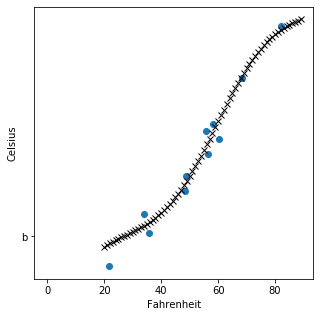

In [53]:
t_range = torch.arange(20., 90.).unsqueeze(-1)

fig = plt.figure(figsize=(5, 5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o', 'b')
plt.plot(t_range.numpy(),seq_model(0.1*t_range).detach().numpy(), 'kx')


In [36]:
t_range.numpy().shape


(70, 1)

In [46]:
t_u.numpy()

array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],
      dtype=float32)

In [44]:
seq_model(t_range).detach().numpy()

array([[30.40131 ],
       [30.401342],
       [30.401356],
       [30.401363],
       [30.401363],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
       [30.401367],
